# Data fusion
1. SentinelHub configuration
2. List collections and tiles
3. Define AOI and visualize it
4. Request collection


## 1. SentinelHub configuration

In [2]:
# Configure plots for inline use in Jupyter Notebook
%matplotlib inline

import datetime as dt

# Utilities
import boto3
import dateutil
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import IPython.display
import shapely.geometry

from utils import plot_image

# Sentinel Hub
from sentinelhub import (
    CRS,
    BBox,
    ByocCollection,
    ByocCollectionAdditionalData,
    ByocCollectionBand,
    ByocTile,
    DataCollection,
    DownloadFailedException,
    MimeType,
    SentinelHubBYOC,
    SentinelHubRequest,
    SHConfig,
    bbox_to_dimensions,
)

config = SHConfig()
config.instance_id = os.environ.get("SH_INSTANCE_ID")
config.sh_client_id = os.environ.get("SH_CLIENT_ID")
config.sh_client_secret = os.environ.get("SH_CLIENT_SECRET")
config.aws_access_key_id = os.environ.get("username")
config.aws_secret_access_key = os.environ.get("password")

## 2. List collections and tiles

In [3]:
# Initialize SentinelHubBYOC class
#https://sentinelhub-py.readthedocs.io/en/latest/reference/sentinelhub.html
byoc = SentinelHubBYOC(config=config)
print ("START--------------------------")
# list collections and tiles
# from: https://sentinelhub-py.readthedocs.io/en/latest/examples/byoc_request.html
collections_iterator = byoc.iter_collections()
my_collections = list(collections_iterator)
for collection in my_collections:
    
    print("Collection name:", collection["name"])
    print("Collection id: ", collection["id"])
    tiles = list(byoc.iter_tiles(collection))
    
    print("-------------------")
print ("end")

START--------------------------
Collection name: urban_audit_2021_city
Collection id:  20774d38-7b2e-43e9-b574-66fa2954da1c
-------------------
Collection name: UrbanAtlas2018_10m_raster_v1
Collection id:  27c95f8f-fb6b-46f2-8f84-2ce7761eeccd
-------------------
Collection name: nuts3_2021
Collection id:  81a17892-38ff-470a-ae46-b64313acd7b3
-------------------
Collection name: urban_audit_2021_fua
Collection id:  b17f90da-1308-439e-b675-6e3a87f883de
-------------------
Collection name: UrbanAtlas2018_10m_raster
Collection id:  bc4099db-f686-4e66-99a6-387a11eb2067
-------------------
Collection name: nuts3_2021
Collection id:  ed7c0bf4-e85f-498c-ad18-f3e83fb89a6f
-------------------
end


## 3. Define AOI and visualize it

In [4]:
### Lux extent box 6.20,49.60 : 6.34,49.66
## test area 2 17.968,  69.43 
##           : 20.376,  70.16 

x1 = 6.0  # degree
y1 = 49.58  # degree
x2 = 6.3 # degree
y2 = 49.62  # degree




# x1 = 19.50  # degree
# y1 = 69.43  # degree
# x2 = 19.51 # degree
# y2 = 69.44  # degree

aoi = BBox([x1, y1, x2, y2], crs=CRS.WGS84)
IPython.display.GeoJSON(shapely.geometry.box(*aoi).__geo_interface__)
#spatial_res = 0.00018   # = 20.038 meters in degree

<IPython.display.GeoJSON object>

## 4. Request collection
Define a DataCollection object from the collectionId.
Get some information about the collection, such as band names, sample format, etc.

In [5]:
#https://sentinelhub-py.readthedocs.io/en/latest/examples/byoc_request.html
#https://eurodatacube.com/notebooks/contributions/LPIS_LULC-Slo.ipynb
data_collection_ua2016 = DataCollection.define_byoc("27c95f8f-fb6b-46f2-8f84-2ce7761eeccd")
data_collection_fua = DataCollection.define_byoc("b17f90da-1308-439e-b675-6e3a87f883de")
data_collection_city = DataCollection.define_byoc("20774d38-7b2e-43e9-b574-66fa2954da1c")

data_collection_pop = DataCollection.define_byoc("b468089b-2627-4787-b984-89c10434f6c6")


data_collection_vegetation_index = DataCollection.define_byoc("472c0398-430d-4157-a62d-603363d7a4e8")  #https://collections.eurodatacube.com/vegetation-indices/

# list band names of the collection
#collection = byoc.get_collection("27c95f8f-fb6b-46f2-8f84-2ce7761eeccd")
#collection["additionalData"]

### Request to SentinelHub
Ingredients for a SentinelHub request are:
- SentinelHub configuration
- AOI and AOI size
- requested collection
- desired output type
- evalscript

The evalscript tells SH how to compute the output. It is made of two functions
- setup(), which specifies which bands are requested and how to structure the output
- evaluatePixel(), which specifies the pixel-wise computation to be done.

More information about evalscript: [https://docs.sentinel-hub.com/api/latest/evalscript/]

How to request multiple collections at once: [https://sentinelhub-py.readthedocs.io/en/latest/examples/data_collections.html#Data-fusion]


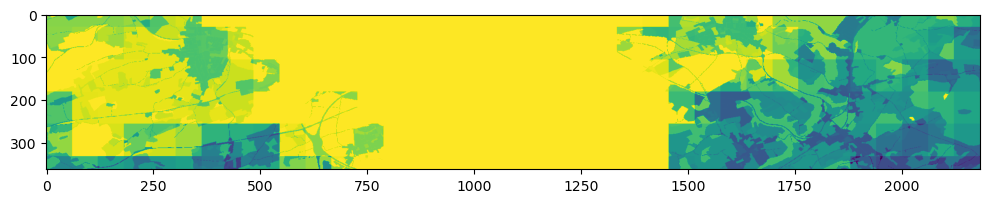

In [6]:
evalscript_combi = """
//VERSION=3
function setup() {
  return {
    input: [{
        datasource: "ua2016",
        bands: ["B1"]
      },
            {
        datasource: "city",
        bands: ["B1"]
      },
      
      {
        datasource: "fua",
        bands: ["B1"]
      },
          {
        datasource: "pop",
        bands: ["populationDensity"]
      }
      
      
    ],
    output: [{
      bands: 1,
      sampleType: "UINT16" // raster format will be UINT16
    }]
  }
}


function evaluatePixel(samples, inputData, inputMetadata, customData, outputMetadata) {
  var ua2016 = samples.ua2016[0]
  var city = samples.city[0]
  var fua = samples.fua[0]
  var pop = samples.pop[0]
  
  if(city.B1 =  null) {
      return [999];
  }
  else {
      return [city.B1+ua2016.B1+pop.populationDensity*100];
  }
}
"""

request = SentinelHubRequest(
    evalscript=evalscript_combi,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=data_collection_ua2016,
            identifier="ua2016",  # has to match Landsat input datasource id in evalscript
            #time_interval=("2020-05-21", "2020-05-23"),
        ),
        SentinelHubRequest.input_data(
            data_collection=data_collection_city,
            identifier="city",  # has to match Sentinel input datasource id in evalscript
            #time_interval=("2020-05-21", "2020-05-23"),
        ),
        SentinelHubRequest.input_data(
            data_collection=data_collection_fua,
            identifier="fua",  # has to match Sentinel input datasource id in evalscript
            #time_interval=("2020-05-21", "2020-05-23"),
        ),
                SentinelHubRequest.input_data(
            data_collection=data_collection_pop,
            identifier="pop",  # has to match Sentinel input datasource id in evalscript
            #time_interval=("2020-05-21", "2020-05-23"),
        ),
    ],
    responses=[SentinelHubRequest.output_response("default", MimeType.PNG)],
    bbox=aoi, #BBox((2.142, 41.378, 2.208, 41.408), CRS.WGS84),
    size=bbox_to_dimensions(aoi, 10),
    config=config,
)

image = request.get_data()[0]

fig, ax = plt.subplots(figsize=(10, 10))

ax.imshow(image)
# ax.set_title(tile_time.date().isoformat(), fontsize=10)

plt.tight_layout()

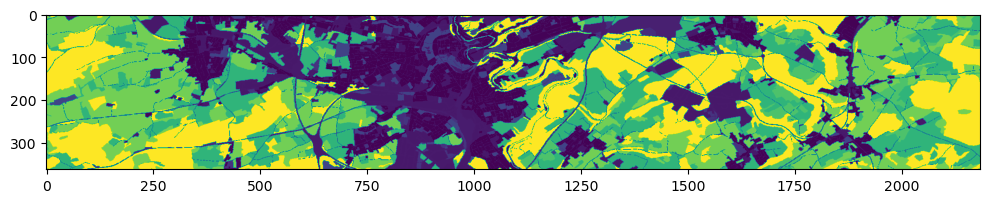

In [37]:
#testing new cube: population per urban atlas class: 1. output
evalscript_combi = """
//VERSION=3
function setup() {
  return {
    input: [{
        datasource: "ua2016",
        bands: ["B1"]
      },

          {
        datasource: "pop",
        bands: ["populationDensity"]
      }
      
      
    ],
    output: [{
      bands: 1,
      sampleType: "UINT16" // raster format will be UINT16
    }]
  }
}


function evaluatePixel(samples)
   {
  var ua2016 = samples.ua2016[0];
  var pop = samples.pop[0];

  return [2.5 * ua2016.B1];

  }

"""

request = SentinelHubRequest(
    evalscript=evalscript_combi,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=data_collection_ua2016,
            identifier="ua2016",  # has to match Landsat input datasource id in evalscript
            #time_interval=("2020-05-21", "2020-05-23"),
        ),

                SentinelHubRequest.input_data(
            data_collection=data_collection_pop,
            identifier="pop",  # has to match Sentinel input datasource id in evalscript
            #time_interval=("2020-05-21", "2020-05-23"),
        ),
    ],
    responses=[SentinelHubRequest.output_response("default", MimeType.PNG)],
    bbox=aoi, #BBox((2.142, 41.378, 2.208, 41.408), CRS.WGS84),
    size=bbox_to_dimensions(aoi, 10),
    config=config,
)

image = request.get_data()[0]

fig, ax = plt.subplots(figsize=(10, 10))

ax.imshow(image)
# ax.set_title(tile_time.date().isoformat(), fontsize=10)

plt.tight_layout()



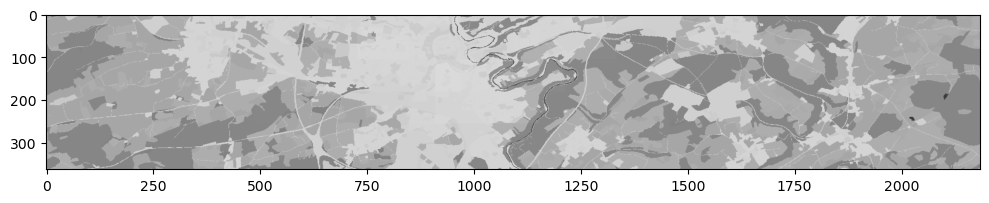

In [40]:
#testing new cube: population per urban atlas class: 1. output with 2bands
evalscript_combi = """
//VERSION=3
function setup() {
  return {
    input: [{
        datasource: "ua2016",
        bands: ["B1"]
      },

          {
        datasource: "pop",
        bands: ["populationDensity"]
      }
      
      
    ],
    output: [{
      bands: 2,
      sampleType: "UINT16" // raster format will be UINT16
    }]
  }
}


function evaluatePixel(samples)
   {
  var ua2016 = samples.ua2016[0];
  var pop = samples.pop[0];

  return [pop.populationDensity, ua2016.B1];

  }

"""

request = SentinelHubRequest(
    evalscript=evalscript_combi,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=data_collection_ua2016,
            identifier="ua2016",  # has to match Landsat input datasource id in evalscript
            #time_interval=("2020-05-21", "2020-05-23"),
        ),

                SentinelHubRequest.input_data(
            data_collection=data_collection_pop,
            identifier="pop",  # has to match Sentinel input datasource id in evalscript
            #time_interval=("2020-05-21", "2020-05-23"),
        ),
    ],
    responses=[SentinelHubRequest.output_response("default", MimeType.PNG)],
    bbox=aoi, #BBox((2.142, 41.378, 2.208, 41.408), CRS.WGS84),
    size=bbox_to_dimensions(aoi, 10),
    config=config,
)

image = request.get_data()[0]

fig, ax = plt.subplots(figsize=(10, 10))

ax.imshow(image)
# ax.set_title(tile_time.date().isoformat(), fontsize=10)

plt.tight_layout()



In [65]:
## storing array

##https://stackoverflow.com/questions/48198288/python-xarray-how-to-convert-individual-band-raster-data-for-multiple-bands-an 
#ä#https://www.geeksforgeeks.org/python-pandas-dataframe-to_xarray/
import pandas as pd 
import numpy as np 
import itertools 
import xarray as xr
array =image
#dataframe = pd.DataFrame(array) [0]
#dataframe
#numbers = image
#unique_numbers = list(set(numbers))
#print(unique_numbers)

#https://docs.xarray.dev/en/stable/generated/xarray.DataArray.groupby.html

#array [1,1,:]


n = len(array)
print (n)



x= array.shape

dim_number = array.ndim

print (x) # size of the array
print (dim_number)

#for t in itertools.product(*array):
#    print (t)
#https://www.geeksforgeeks.org/iterative-approach-to-print-all-combinations-of-an-array/
## finding all combination wiht count of population and urbanAtlas

#image

#df = pd.DataFrame(array).stack().rename_axis(['y', 'x']).reset_index(name='val')  # works with 1 band


#xcube = xr.DataArray(image)
#xcube

data = xr.DataArray(array, dims=("x", "y","t"), coords={"y": [10, 20]})



data

362
(362, 2184, 4)
3


ValueError: conflicting sizes for dimension 'y': length 2184 on the data but length 2 on coordinate 'y'

In [32]:
#https://www.geeksforgeeks.org/basics-of-numpy-arrays/
x = image
x.shape


(362, 2184, 4)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


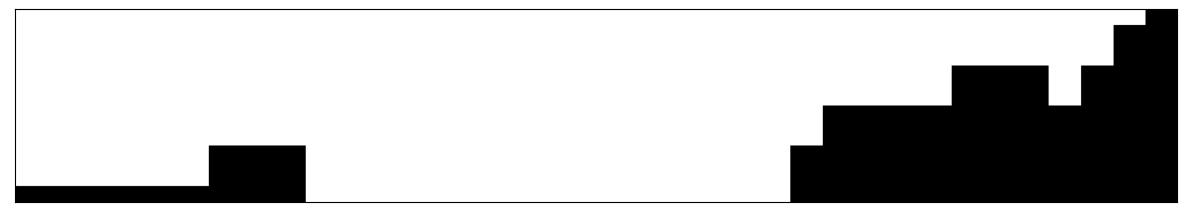

In [29]:
plot_image(image, factor=1.0, cmap=plt.cm.Greys_r)